In [3]:
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import cv2
from cv2 import cvtColor
import pickle as pkl

%load_ext autoreload
%autoreload 2

In [5]:
def to_grayscale(img):
    original_shape = img.shape[:2]
    img = cvtColor(img,cv2.COLOR_BGR2GRAY).astype(float)
    img /= np.max(img)
    return img
def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz

def plot_img_at(img, coord, label='Target Location',
    vmin = 0.4,
    vmax = 0.8,ax=None):
    '''
        Plot the 3D slicing view of img at coord.
    '''
    img = np.array(img)
    img += -np.min(img)
    img /= np.max(img)
   
    l,p,s = coord
    
    
    target_marker = 'x'
    target_size = 50
    target_color = 'yellow'

  
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    
    # Only plot the horizontal slice.
    ax.imshow(np.squeeze(img[:,:,s]).T,cmap='gray',vmin=vmin,vmax=vmax)
    ax.scatter(l,p,marker = target_marker,s=target_size,color = target_color,label=label)
    ax.legend()    
    return ax
def visualize_body(img,target_pixel=None,label=None,
                    vmin = 0.4,
                    vmax = 0.8,ax=None):
    img = sitk.GetArrayViewFromImage(img).astype(float)
    img = np.swapaxes(img,0,2)
    if target_pixel is None:
        target_pixel = np.array(centroid3(img))
        label = 'Centroid location'
    plot_img_at(img,np.array(target_pixel,dtype=int),label,vmin,vmax,ax)
    
    
def flip_img(input_img,orders):
    flipped_ct = sitk.Flip(input_img,orders)
    flipped_ct = sitk.GetImageFromArray(sitk.GetArrayFromImage(flipped_ct).astype(np.float64))
    flipped_ct.SetOrigin(input_img.GetOrigin())
    flipped_ct.SetSpacing(input_img.GetSpacing())
    return flipped_ct

In [6]:

body_ct = sitk.ReadImage('./data/nifty/CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])

In [7]:
import os
obs_path = './data/observations/'
fs = os.listdir(obs_path)

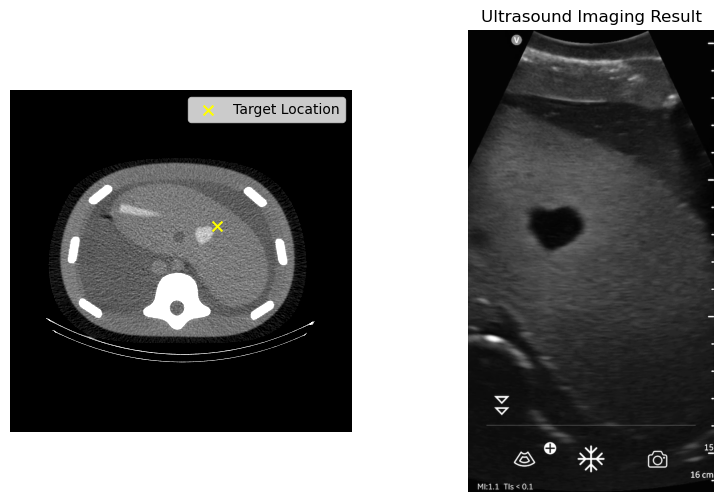

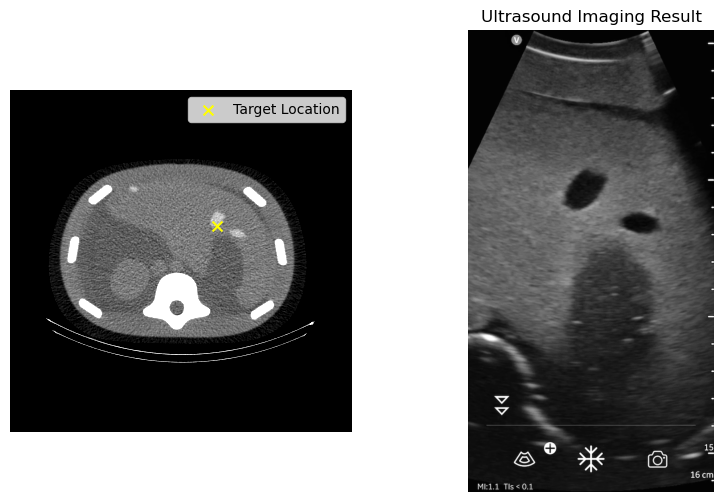

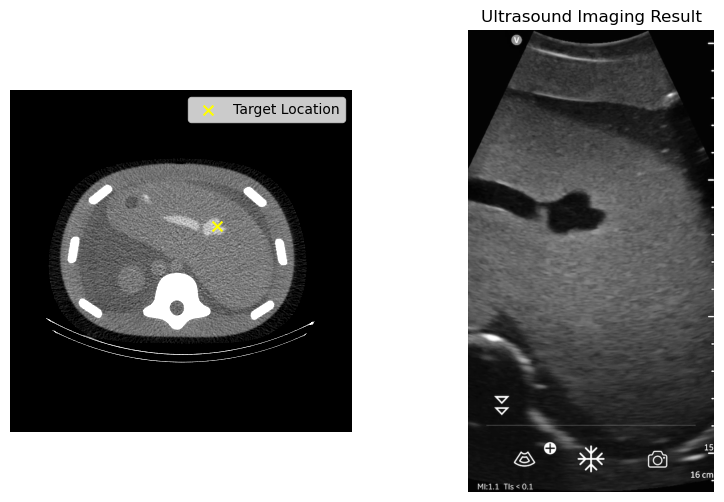

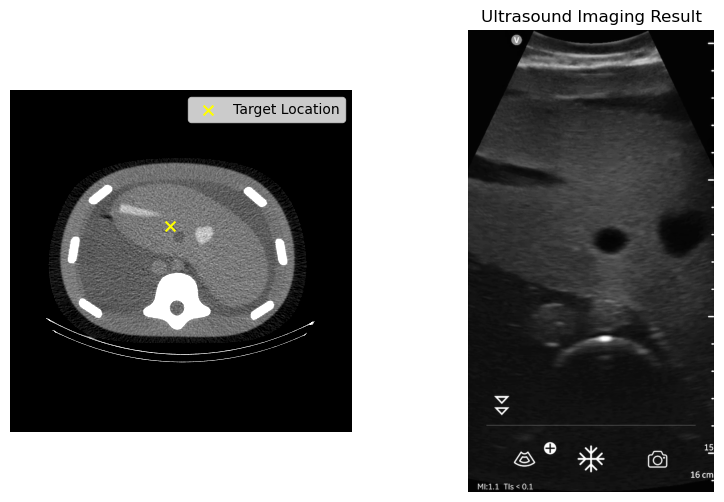

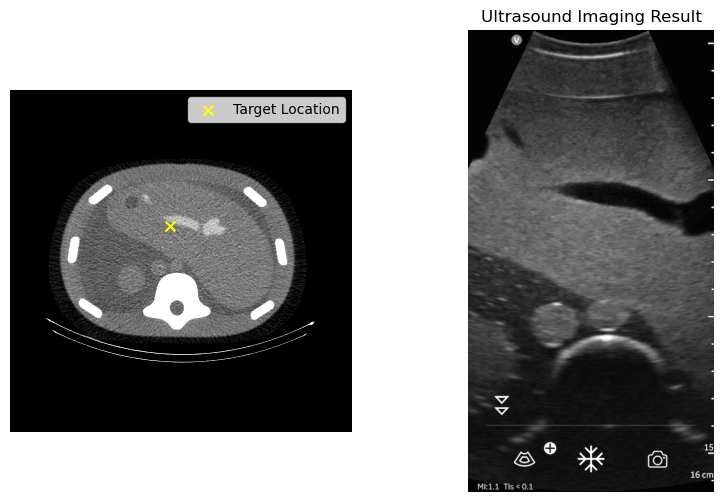

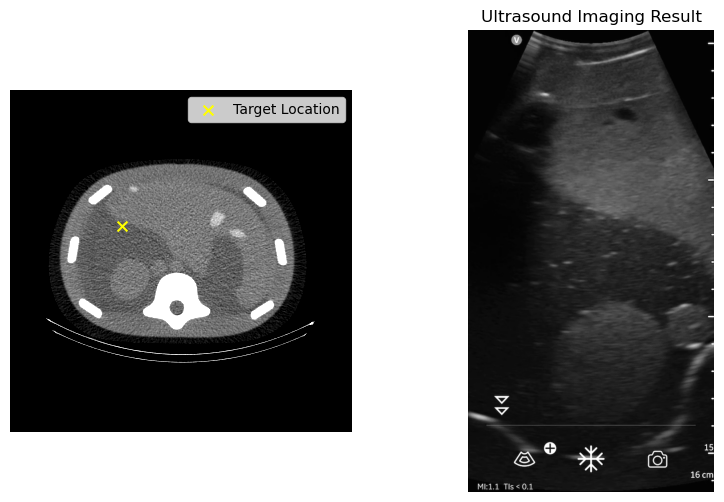

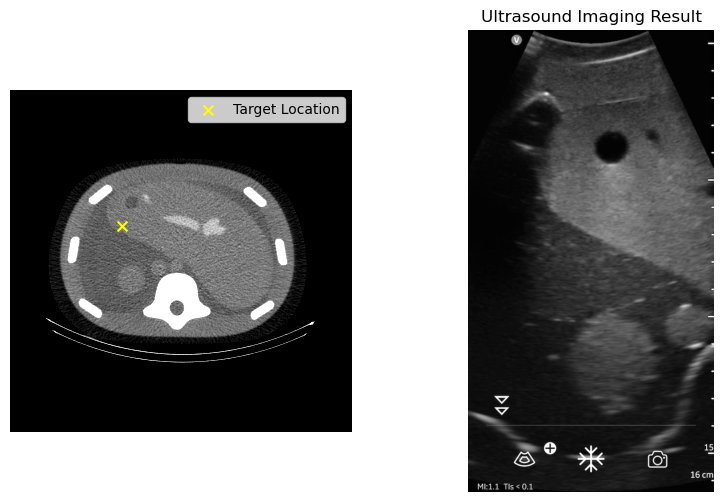

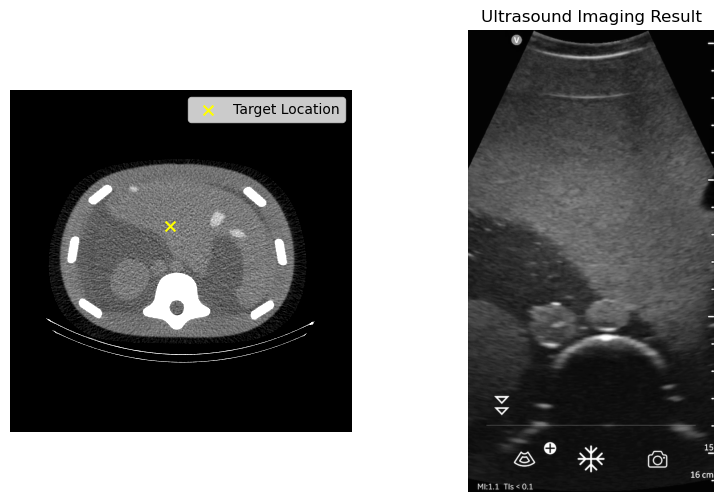

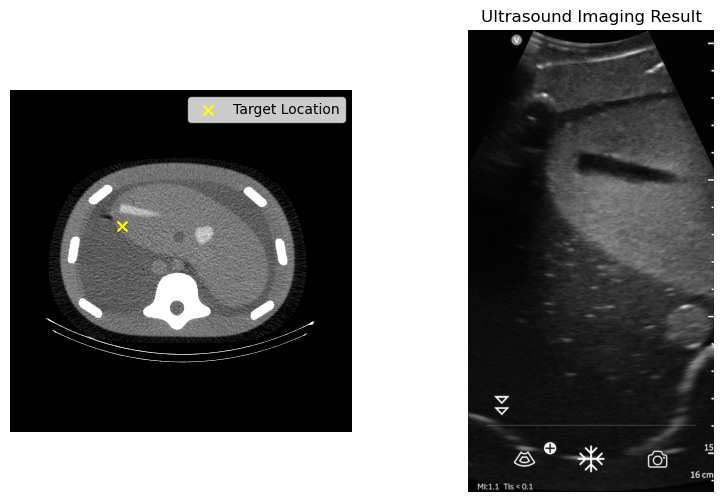

In [8]:
# x_cand = [-80,-40,-20,0,20]
# z_cand = [-10,-5,0,5,10]

i = 0
for f in fs:

    
    with open(obs_path+f,'rb') as fp:
        obs = pkl.load(fp)
    
    loc = obs['ct_target_loc']
    cframe = obs['with_slice_matching']['center_frame']
    plt.figure(figsize=(15,6))
    
    pix = body_ct.TransformPhysicalPointToIndex(loc)
    # visualize_vessel(original_vessel_ct,pix,'Target Location')
    ax = plt.subplot(1,3,1)
    visualize_body(body_ct,pix,'Target Location',vmin=0.6,vmax=0.8,ax=ax)


    ax = plt.subplot(1,3,2)
    ax.axis('off')
    ax.imshow(to_grayscale(cframe[100:1040]),cmap = 'gray')
    ax.set_title('Ultrasound Imaging Result')


    # ax = plt.subplot(1,3,3)
    # ax.axis('off')
    # ax.imshow(to_grayscale(benchmark[100:1040]),cmap = 'gray')
    # ax.set_title('Benchmark')

    # plt.savefig('./figures/{}.png'.format(i))
    plt.show()
    

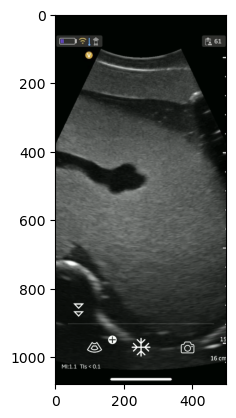

-0.008845026359105293


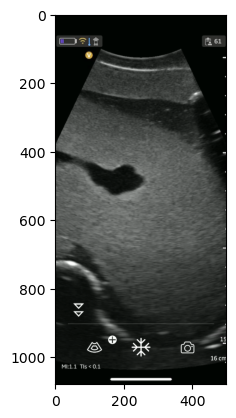

-0.007718773269750415


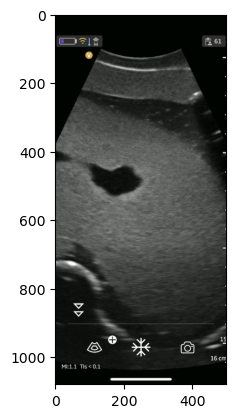

-0.006626662765244415


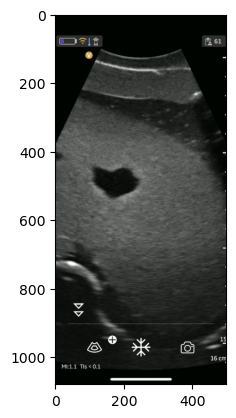

-0.00552671973531102


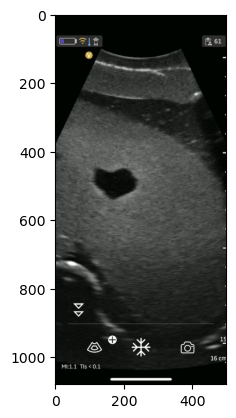

-0.004409638993603013


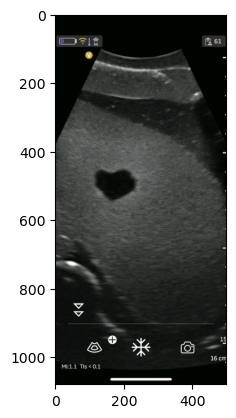

-0.003259113345069564


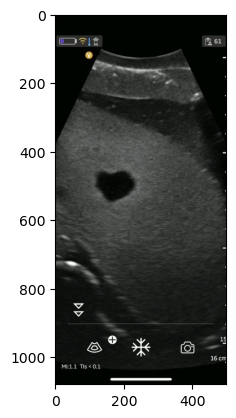

-0.0021778578480377564


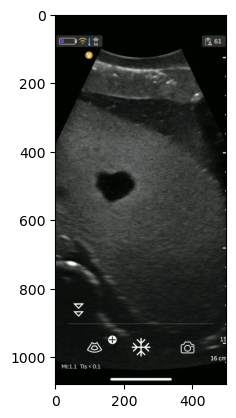

-0.0009918773224439764


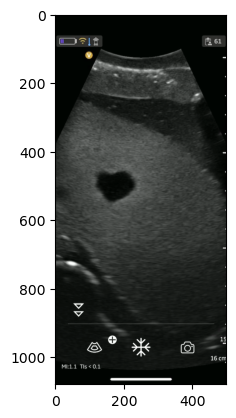

-8.369972640379086e-06


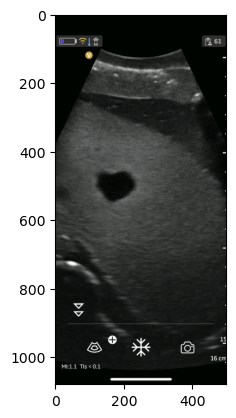

3.132074005339491e-05


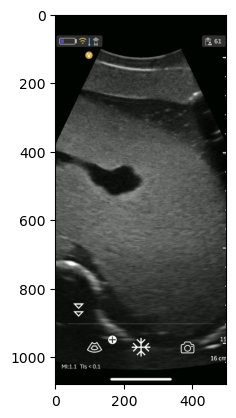

-9.296801999453264e-05


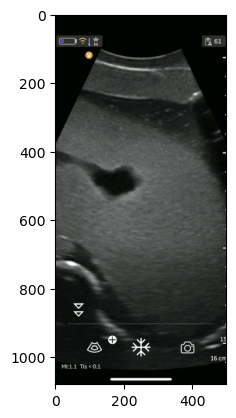

-6.366759799823762e-05


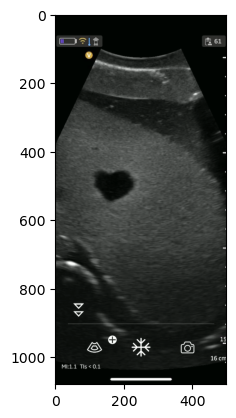

0.0010672967182093762


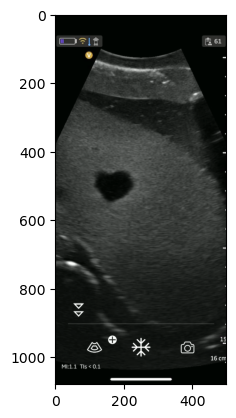

0.002159494478152127


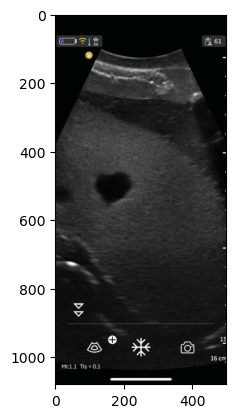

0.003269866176231165


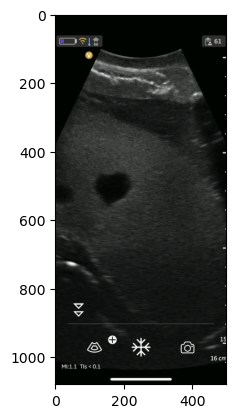

0.00442243105491566


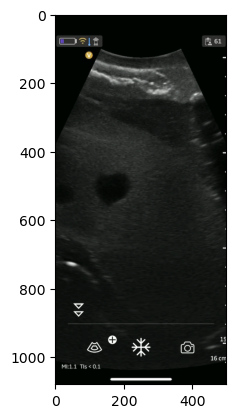

0.005523493407749283


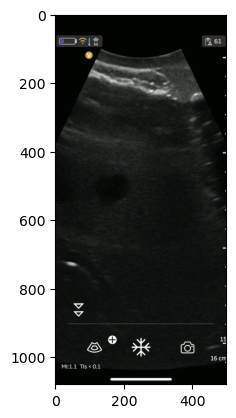

0.0066111876507283646


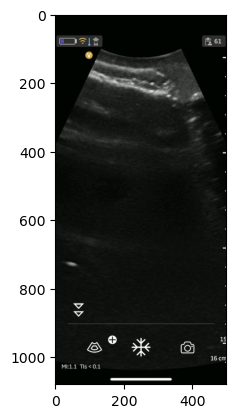

0.007727850911620496


In [11]:
fs = obs['with_slice_matching']['all_frames']
ps = obs['with_slice_matching']['all_poses']
cp = obs['with_slice_matching']['center_pose']
of = []
for fr,p in zip(fs,ps):
    plt.imshow(fr)
    plt.show()

    print(np.array(cp)[0]-np.array(p)[0])
    of.append(np.array(cp)[0]-np.array(p)[0])